### Assignment 7

Q1: On np-based implementation: Code a cross-entropy cost function. Does cross-entropy train faster than MSE? Is accuracy improved?

### What is cross-entropy cost function?

Entropy can be measured as the uncertainty in the variables’ possible outcomes. That is the less the entropy the more the predictability.

The formula to calculate the entropy is:

$$H(x) = -\int_x p(x) log(p(x)) dx \;\;\;\text{if x is continuous}$$

$$H(x) = -\sum_x p(x) log(p(x))    \;\;\;\text{if x is discrete}$$

Cross-entropy cost function is a cost function used in classification problems.

Cross-entropy function can be defined as the difference between two probability distributions which is the true probability distribution and the predicted probability distribution. 

In this context, we are using cross-entropy to reduce the loss function with every iteration. 

The cross entropy Loss function can be defined as:

$$L = -\sum_{i=1}^n ylog(p_i) \;\;\;\text{for n classes}$$


where *y* is the predicted probability value and *p* is the true probability value.

Categorical cross entropy is the mean cross entropy across the system. Formula:

$$L/N\;\;\;\text{where N is the number of samples}$$

### Testing Cross-entropy on numpy minibatch

In [53]:
import numpy as np
print("Numpy version: "+np.__version__)
from sklearn import __version__ as skver
print("Scikit-learn version: "+skver)
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pylab as plt
print("Matplotlib version: "+plt.__version__)

Numpy version: 1.19.5
Scikit-learn version: 1.0.2
Matplotlib version: 1.19.5


### STEP 1:

Let's generate data with 2000 samples

In [54]:
N = 2000  # number of samples
X, Y = make_blobs(n_samples=N, centers=[[1, 1], [-1, 1], [1, -1], [-1, -1]], cluster_std=0.5)

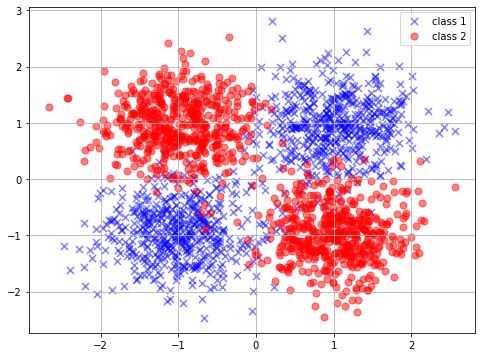

In [55]:
# Make it a two-class problem:
Y[Y==2] = 1.0
Y[Y==3] = 0.0 

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[Y==0, 0], X[Y==0, 1], c='b', marker='x', 
           s=50, alpha=0.5, label='class 1')
ax.scatter(X[Y==1, 0], X[Y==1, 1], c='r', marker='o', 
           s=50, alpha=0.5, label='class 2')
plt.legend()
plt.grid()

Let's create a meshgrid for the probability plots:

In [56]:
# Simple train, test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.25, test_size=0.75)

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

Let's save the datasets:

In [57]:
import pickle
data1 = (X, Y)
data2 = (X_train, X_test, Y_train, Y_test)

# open a file, where you ant to store the data
file1 = open(r'make_blobs1.pck', 'wb')
file2 = open(r'make_blobs2.pck', 'wb')

# dump information to that file
pickle.dump(data1, file1)
pickle.dump(data2, file2)
file1.close()
file2.close()

We use our previous pure-numpy ANN implementation, with a

- Cross-entropy cost function
- An output layer with one neuron (two classes) and a sigmoid activation function
- A single hidden layer with tanh activation function
- Minibatch training

In other words, a 2-5-1 ann!

### STEP 2:

Building the Layer

In [58]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

class Layer:
    def __init__(self, features, n, activation="tanh"):        
        self.n_input = features
        self.n_neurons = n
        self.activation = activation
        self.W = np.zeros(shape=(features, n)) # weights
        self.b = np.zeros(shape=(n, )) # bias
        self.initialize_parameters()  
        self.z = np.zeros(shape=(n)) # z = Wx + b
        self.y = np.zeros(shape=(n)) # y = sgm(z)
        
    def initialize_parameters(self):
        if self.activation == "tanh":
            self.W = np.array(np.random.uniform(low  = -np.sqrt(6.0/(self.n_input + self.n_neurons)),
                                                high = np.sqrt(6.0/(self.n_input + self.n_neurons)),
                                                size = (self.n_input, self.n_neurons)))
        else: 
            self.W = np.array(np.zeros(shape=(self.n_input, self.n_neurons)))
            
        # zero bias
        self.b = np.zeros(shape=(self.n_neurons, ))
        
    def output(self, x):  #  x is an array N_input x 1
        self.z = np.dot(x, self.W) + self.b
        if self.activation == "tanh":
            self.y = np.tanh(self.z)
        elif self.activation == "sigmoid":
            self.y = sigmoid(self.z)
        return self.y

Building the classifier 

In [59]:
class nn1h:
    def __init__(self, features, n_hidden):
        self.layers = []
        self.n_output = 1
        self.n_hidden = n_hidden
        self.output_activation = "sigmoid"
        if n_hidden > 0:
            # one hidden layers of n_hidden neurons.
            self.layers.append(Layer(features, n_hidden)) #  hidden layers use tanh activation
            
            # output layer: one neuron output layer
            self.layers.append(Layer(n_hidden, self.n_output, activation="sigmoid"))
        else:
            # if no hidden layers, then only one output layer
            self.layers.append(Layer(features, self.n_output, activation="sigmoid"))
     
    # feedforward
    def predict_proba(self, x):
        # feedforward input through each layer downstream
        for layer in self.layers:
            x = layer.output(x)
        return x
    
    # backpropagation will be implemented in a training class!
        
    # round off to binary output True or False, use for inference
    def predict(self, x):
        x = self.predict_proba(x)
        if self.output_activation == "sigmoid":
            return x > 0.5
        elif self.output_activation == "tanh":
            return x > 0.0
        
    def reset(self):
        for layer in self.layers:
            layer.initialize_parameters()
            
#### Defining Categorical cross entropy loss function as mathematically described above

    def categorical_cross_entropy(self,x,y):
        num_samples = y.shape[0]
        # calculate the categorical cross-entropy loss
        loss = -np.sum(y * np.log(self.predict_proba(x)[:,0])) / num_samples
        return loss

In [60]:
class Trainer:
    def __init__(self, classifier, learning_rate=1.0, max_epoch=1000):
        self.classifier = classifier
        self.lr = learning_rate
        self.train_cost = np.zeros(shape=(max_epoch,))
        self.test_cost = np.zeros(shape=(max_epoch, ))   
        self.max_epoch = max_epoch
        self.current_epoch = 0

    def update(self, data_train, label_train, data_test, label_test, batch_size=32):
        if self.current_epoch == 0:  
            self.train_cost[0] =  self.classifier.categorical_cross_entropy(data_train, label_train) 
            self.test_cost[0] =  self.classifier.categorical_cross_entropy(data_test, label_test) 
        # Present mini-batches in different order each epoch
        else:        
            rand_perm = np.random.permutation(len(label_train))
            data_train = data_train[rand_perm, :].copy()
            label_train = label_train[rand_perm].copy()
            self.minibach_eval(data_train, label_train, batch_size)
            self.train_cost[self.current_epoch] = self.classifier.categorical_cross_entropy(data_train, label_train) 
            self.test_cost[self.current_epoch] =  self.classifier.categorical_cross_entropy(data_test, label_test)               
        self.current_epoch += 1
    
    def reset(self):
        self.classifier.reset()        

    def minibach_eval(self, data, labels, batch_size=32):
        averaged_cost = 0.0
        n = len(labels)
        for nbatches, (start, end) in enumerate(zip(range(0, n, batch_size), range(batch_size, n + 1, batch_size))):
            self.train(data[start:end], labels[start:end])
        #return averaged_cost/nbatches
    
    def train(self, data, labels):
        n = len(labels)
        error = (self.classifier.predict_proba(data)[:, 0] - labels)[:, np.newaxis]
        nlayer = len(self.classifier.layers)
        
        # This considers an outer layer with one neuron
        layer_idx = nlayer - 1 
        out_layer = self.classifier.layers[layer_idx]
        tmp = np.multiply(error, sigmoid(out_layer.z) * (1.0 - sigmoid(out_layer.z)))
        grad_b = np.mean(tmp, axis=0)
        if nlayer == 1:
            grad_w = np.mean(np.multiply(np.tile(tmp, (1, out_layer.n_input)), data), axis=0)
        else:
            hidden_layer = self.classifier.layers[layer_idx - 1]
            grad_w = np.mean(np.multiply(np.tile(tmp, (1, out_layer.n_input)), hidden_layer.y), axis=0) 
            
        # gradient descent
        self.classifier.layers[layer_idx].W -= self.lr*grad_w[:, np.newaxis]
        self.classifier.layers[layer_idx].b -= self.lr*grad_b
        
        # Train the hidden layer
        if nlayer > 1:
            nh = out_layer.n_input
            e = np.tile(error * sigmoid(out_layer.z) * (1.0 - sigmoid(out_layer.z)), (1, nh))
            tmp = np.multiply(np.multiply(e, 1.0 - np.tanh(hidden_layer.z)**2), np.tile(out_layer.W.T, (n, 1)))
            grad_b = np.mean(tmp, axis=0)
            grad_w = np.dot(tmp.T, data).T
            
            # gradient descent
            self.classifier.layers[layer_idx-1].W -= self.lr * grad_w
            self.classifier.layers[layer_idx-1].b -= self.lr * grad_b

### Training epoch by epoch

In [61]:
X.shape

(2000, 2)

In [62]:
classifier = nn1h(X.shape[1], n_hidden = 5)
trainer = Trainer(classifier, learning_rate=0.5, max_epoch=1000)

In [63]:
print(classifier.predict_proba(X_train))

[[0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]

In [64]:
y_true=Y_train

In [65]:
classifier.categorical_cross_entropy(X_train,y_true)

0.3535050620855721

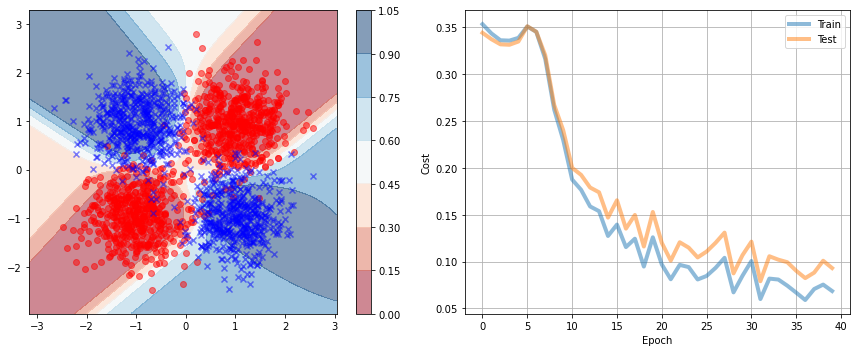

In [105]:
trainer.update(X_train, Y_train, X_test, Y_test, batch_size=10)
pred_labels = classifier.predict(X_test)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,0]
cf = ax.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.RdBu, alpha=0.5, vmin=0.0, vmax=1.0)
plt.colorbar(cf)
ax.scatter(X[Y==0, 0], X[Y==0, 1], color='r', marker='o', alpha=0.5)
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='b', marker='x', alpha=0.5)

ax = fig.add_subplot(1, 2, 2)
ax.plot(np.arange(0, trainer.current_epoch, step=1), 
        trainer.train_cost[:trainer.current_epoch], linewidth=4, alpha=0.5, label="Train")
ax.plot(np.arange(0, trainer.current_epoch, step=1), 
        trainer.test_cost[:trainer.current_epoch], linewidth=4, alpha=0.5, label="Test")
ax.set_xlabel('Epoch')
ax.set_ylabel('Cost')
plt.legend()
plt.grid()
plt.tight_layout()

### Conclusion

Categorical cross entropy was 0.35 which is higher than that of Mean squared error. However, training the data set took less number of trials. The dataset trained faster than Mean Squared Error. The accuracy of the test data was lesser than that of MSE.

## Tensorflow implementation

Q2: On tensorflow implementation: Code a minibatch. What's the best batch size for an MSE loss?

Let's use:

- A cross-entropy error cost function/mse
- An output layer with one neuron (two classes) and sigmoid activation function
- A single hidden layer with tanh activation function
- An ADAM learning rate
- MiniBatch mode

In [115]:
import tensorflow as tf
print("Tensorflow version: " + tf.__version__)

Tensorflow version: 2.7.0


In [116]:
import pickle

# open a file, where you stored the pickled data
file1 = open(r'make_blobs1.pck', 'rb')
file2 = open(r'make_blobs2.pck', 'rb')

# dump information to that file
(X, y) = pickle.load(file1)
(X_train, X_test, y_train, y_test) = pickle.load(file2)

# close the file
file1.close()
file2.close()

In [117]:
X_train, y_train

(array([[ 1.10322442, -1.41409235],
        [-1.0279297 , -1.79486049],
        [ 0.46950486, -1.14680502],
        [ 0.87051184,  0.75052834],
        [ 1.45229839, -0.7492367 ],
        [-0.97506694,  0.43408162],
        [-1.3206953 ,  1.24217601],
        [-1.25671357,  1.37041921],
        [-0.0277761 ,  1.34118996],
        [ 0.39744148,  0.55421599],
        [ 0.98559823,  1.43811144],
        [-1.18153226, -1.52233042],
        [ 0.55992954,  0.91941178],
        [-2.02619357,  0.55117948],
        [ 1.68170003,  1.23631   ],
        [ 1.21992693, -1.738874  ],
        [-0.99733258,  0.84426535],
        [ 0.21058849,  2.80057431],
        [ 1.4475502 , -0.58678868],
        [-0.84868247,  1.17970577],
        [-1.51663157,  0.98034731],
        [ 0.6938262 ,  1.48640538],
        [-1.16867049,  1.68702243],
        [-0.43979587, -0.91749495],
        [ 1.24082422, -0.7712506 ],
        [ 0.88924823,  0.70594687],
        [ 0.27736681, -0.78176699],
        [ 0.88929966,  0.576

In [118]:
from tensorflow import keras
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=[None, 2]))
model.add(keras.layers.Dense(5, activation="tanh"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [119]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, None, 5)           15        
                                                                 
 dense_5 (Dense)             (None, None, 1)           6         
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [120]:
from keras import losses 
from keras import metrics

model.compile(loss = 'mean_squared_error', metrics = [metrics.categorical_accuracy])
#model.compile(loss = 'categorical_crossentropy', metrics = [metrics.categorical_accuracy])

### Keras mini-batch training 

In [121]:
history = model.fit(X_train, y_train, batch_size=10, epochs = 100)

Epoch 1/100
50/50 [==============================] - 1s 2ms/step - loss: 0.2627 - categorical_accuracy: 1.0000
Epoch 2/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2568 - categorical_accuracy: 1.0000
Epoch 3/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2524 - categorical_accuracy: 1.0000
Epoch 4/100
50/50 [==============================] - 0s 1ms/step - loss: 0.2486 - categorical_accuracy: 1.0000
Epoch 5/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2455 - categorical_accuracy: 1.0000
Epoch 6/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2425 - categorical_accuracy: 1.0000
Epoch 7/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2400 - categorical_accuracy: 1.0000
Epoch 8/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2376 - categorical_accuracy: 1.0000
Epoch 9/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2350 - categorical_accuracy: 1.0000
E

50/50 [==============================] - 0s 2ms/step - loss: 0.0569 - categorical_accuracy: 1.0000
Epoch 70/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0563 - categorical_accuracy: 1.0000
Epoch 71/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0557 - categorical_accuracy: 1.0000
Epoch 72/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0552 - categorical_accuracy: 1.0000
Epoch 73/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0546 - categorical_accuracy: 1.0000
Epoch 74/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0541 - categorical_accuracy: 1.0000
Epoch 75/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0537 - categorical_accuracy: 1.0000
Epoch 76/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0532 - categorical_accuracy: 1.0000
Epoch 77/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0528 - categorical_accuracy: 1.0000
Epoch

In [122]:
model.evaluate(X_test, y_test)

47/47 [==============================] - 0s 2ms/step - loss: 0.0474 - categorical_accuracy: 1.0000


[0.04737215116620064, 1.0]

In [23]:
history.history

{'loss': [0.27820736169815063,
  0.2660125195980072,
  0.25523924827575684,
  0.2462841272354126,
  0.23869867622852325,
  0.23227696120738983,
  0.22654952108860016,
  0.2214076966047287,
  0.21624593436717987,
  0.2111632376909256,
  0.20621387660503387,
  0.20097577571868896,
  0.19566677510738373,
  0.19037415087223053,
  0.18481726944446564,
  0.17901982367038727,
  0.17292052507400513,
  0.1671007126569748,
  0.1612222045660019,
  0.15536664426326752,
  0.14950066804885864,
  0.14359575510025024,
  0.13784435391426086,
  0.1322125792503357,
  0.12641699612140656,
  0.12095017731189728,
  0.11604253202676773,
  0.11141786724328995,
  0.10697951167821884,
  0.10268165916204453,
  0.09857319295406342,
  0.09469448775053024,
  0.09099473059177399,
  0.08749980479478836,
  0.08446329087018967,
  0.0814816877245903,
  0.07878643274307251,
  0.076263427734375,
  0.07383843511343002,
  0.07157666981220245,
  0.06958998739719391,
  0.06767602264881134,
  0.0658976137638092,
  0.0642962157

In [24]:
import numpy as np
print("Numpy version: "+np.__version__)
%matplotlib inline
import matplotlib.pylab as plt
print("Matplotlib version: "+plt.__version__)

Numpy version: 1.19.5
Matplotlib version: 1.19.5


In [25]:
import numpy as np

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

In [26]:
xx.shape, yy.shape

((128, 122), (128, 122))

In [27]:
xx

array([[-3.0819869, -3.0319869, -2.9819869, ...,  2.8680131,  2.9180131,
         2.9680131],
       [-3.0819869, -3.0319869, -2.9819869, ...,  2.8680131,  2.9180131,
         2.9680131],
       [-3.0819869, -3.0319869, -2.9819869, ...,  2.8680131,  2.9180131,
         2.9680131],
       ...,
       [-3.0819869, -3.0319869, -2.9819869, ...,  2.8680131,  2.9180131,
         2.9680131],
       [-3.0819869, -3.0319869, -2.9819869, ...,  2.8680131,  2.9180131,
         2.9680131],
       [-3.0819869, -3.0319869, -2.9819869, ...,  2.8680131,  2.9180131,
         2.9680131]])

In [28]:
yy

array([[-3.4450354, -3.4450354, -3.4450354, ..., -3.4450354, -3.4450354,
        -3.4450354],
       [-3.3950354, -3.3950354, -3.3950354, ..., -3.3950354, -3.3950354,
        -3.3950354],
       [-3.3450354, -3.3450354, -3.3450354, ..., -3.3450354, -3.3450354,
        -3.3450354],
       ...,
       [ 2.8049646,  2.8049646,  2.8049646, ...,  2.8049646,  2.8049646,
         2.8049646],
       [ 2.8549646,  2.8549646,  2.8549646, ...,  2.8549646,  2.8549646,
         2.8549646],
       [ 2.9049646,  2.9049646,  2.9049646, ...,  2.9049646,  2.9049646,
         2.9049646]])

In [29]:
np.c_[xx.ravel(), yy.ravel()].shape

(15616, 2)

In [30]:
np.c_[xx.ravel(), yy.ravel()]

array([[-3.0819869, -3.4450354],
       [-3.0319869, -3.4450354],
       [-2.9819869, -3.4450354],
       ...,
       [ 2.8680131,  2.9049646],
       [ 2.9180131,  2.9049646],
       [ 2.9680131,  2.9049646]])

In [31]:
yhat = model.predict(np.c_[xx.ravel(), yy.ravel()])

In [32]:
yhat.shape

(15616, 1)

In [33]:
yhatp = yhat.reshape(xx.shape)

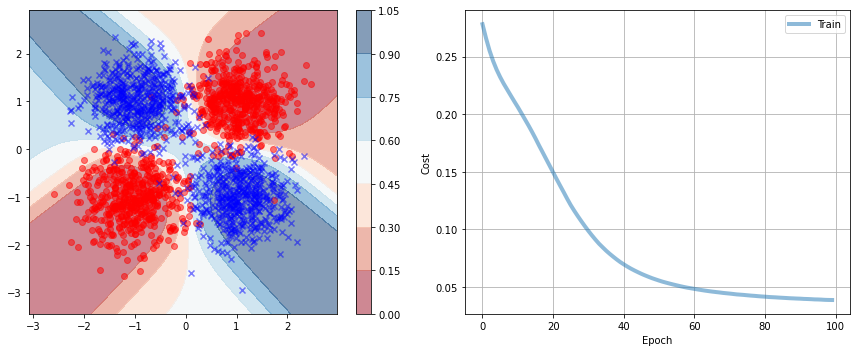

In [34]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'], linewidth=4, alpha=0.5, label='Train')
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.legend()
ax = fig.add_subplot(1, 2, 1)

cf = ax.contourf(xx, yy, yhatp, cmap=plt.cm.RdBu, alpha=0.5, vmin=0.0, vmax=1.0)
plt.colorbar(cf)
ax.scatter(X[y==0, 0], X[y==0, 1], color='r', marker='o', alpha=0.5)
ax.scatter(X[y==1, 0], X[y==1, 1], color='b', marker='x', alpha=0.5)
plt.tight_layout()

### Conclusion 

Categorical cross entropy with mini batch implementation had almost 0 error.
MSE was lower when trained with minibatch than batch training 
Minibatch has a higher accuracy and trained faster than batch training 